# Idea
The idea is that we predict rotated linear dimension position from lines and text from the drawing.

# Thoughts
Basic logic is we split dataset to input lines or texts positions StartPoint, EndPoint, Position XYZ and predict dimension extension line poistion XLine1Point, XLine2Point XYZ.

We going to group samples by FileId. That is each sample will contain variable length data (attributes of variable number of  lines and text) and variable output data (variable number of dimensions).

I intend to [use RNN for it](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
import torch
from torch import nn
from torch.utils.data import Dataset, SubsetRandomSampler
from torch.nn import functional as F

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
device

device(type='cuda')

# Dataset implementation

In [3]:
test_data = pd.read_pickle('test_dataset.pickle')
test_data

,ClassName,FileId,XLine1Point.X,XLine1Point.Y,XLine1Point.Z,XLine2Point.X,XLine2Point.Y,XLine2Point.Z,StartPoint.X,StartPoint.Y,StartPoint.Z,EndPoint.X,EndPoint.Y,EndPoint.Z,Position.X,Position.Y,Position.Z
0,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.695776,35.642180,0.0
1,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,10.433374,0.0
2,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,6.266707,0.0
3,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,22.584136,0.0
4,AcDbText,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733352,18.417470,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89231,AcDbText,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.169657,92.228915,0.0
89232,AcDbLine,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,20.2884,155.228915,0.0,0.2884,155.228915,0.0,NaN,NaN,NaN
89233,AcDbLine,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,5.2884,145.228915,0.0,20.2884,145.228915,0.0,NaN,NaN,NaN
89234,AcDbText,09bb1674-bff4-4ac7-a86d-60a9600ce899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.663400,1.478915,0.0


In [4]:
from dataset import DwgDataset
batch_size = 2

dwg_dataset = DwgDataset(pickle_file = 'test_dataset.pickle', batch_size = batch_size)

train_loader = dwg_dataset.train_loader
val_loader   = dwg_dataset.val_loader
test_loader  = dwg_dataset.test_loader

ent_features = dwg_dataset.entities.ent_features
dim_features = dwg_dataset.entities.dim_features

In [5]:
for c,d in dwg_dataset.entities:
    # print(c.shape, d.shape)
    # make sure we have every training sample not empty
    assert( c.shape[0] != 0)    

In [6]:
(a,b) = next(iter(train_loader))
print(len(a),len(b))
for (x,y) in iter(train_loader):
    for xx in x:
        print(xx.shape)
        pass
    for yy in y:
        print(yy.shape)
    # print(a.shape,b.shape)
    break

2 2
torch.Size([4390, 9])
torch.Size([955, 9])
torch.Size([16, 6])
torch.Size([0, 6])


# Model and training


In [7]:
from model import RnnDecoder, RnnEncoder
rnn_encoder = RnnEncoder(ent_features, 1024).to(device)
rnn_decoder = RnnDecoder(1024, dim_features).to(device)

In [8]:
(x,y) = next(iter(train_loader))
print('inputs','x:',len(x),'x',x[0].shape,'y:',len(y),'x',y[0].shape)
outs_numbers, learned = rnn_encoder(x)
print('learned shape:', learned.shape)
print("outs shape:", outs_numbers.shape, 'outs_value', outs_numbers)
# make sure something is passed
outs_numbers[0] = 42
decoded = rnn_decoder(outs_numbers, learned)
print('decoded:',len(decoded),'x', decoded[0].shape)

inputs x: 2 x torch.Size([435, 9]) y: 2 x torch.Size([43, 6])
learned shape: torch.Size([2, 1024])
outs shape: torch.Size([2, 1]) outs_value tensor([[ 355],
        [1038]], device='cuda:0', dtype=torch.int32)
decoded: 2 x torch.Size([42, 6])


In [9]:
%matplotlib inline
from train import train_model, plot_history

[0-0 @ 0.2 sec] Log10 Loss: 6.355729 Train err: 100.0%
[0-1 @ 0.3 sec] Log10 Loss: 5.999514 Train err: 100.0%
[0-2 @ 0.6 sec] Log10 Loss: 6.678677 Train err: 100.0%
[0-3 @ 0.7 sec] Log10 Loss: 6.008660 Train err: 100.0%
[0-4 @ 1.0 sec] Log10 Loss: 6.892268 Train err: 100.0%
[0-5 @ 1.1 sec] Log10 Loss: 5.911712 Train err: 100.0%
[0-6 @ 1.4 sec] Log10 Loss: 6.690856 Train err: 100.0%
[0-7 @ 1.8 sec] Log10 Loss: 6.430057 Train err: 100.0%
[0-8 @ 3.6 sec] Log10 Loss: 8.280715 Train err: 100.0%
[0-9 @ 4.1 sec] Log10 Loss: 5.728044 Train err: 100.0%
[0-10 @ 4.2 sec] Log10 Loss: 4.254210 Train err: 100.0%
Epoch validation accuracy: 0.000
[1-0 @ 4.8 sec] Log10 Loss: 5.890104 Train err: 100.0%
[1-1 @ 5.4 sec] Log10 Loss: 6.845169 Train err: 100.0%
[1-2 @ 5.5 sec] Log10 Loss: 5.689315 Train err: 100.0%
[1-3 @ 7.3 sec] Log10 Loss: 8.279880 Train err: 100.0%
[1-4 @ 7.6 sec] Log10 Loss: 6.700328 Train err: 100.0%
[1-5 @ 7.8 sec] Log10 Loss: 5.943002 Train err: 100.0%
[1-6 @ 7.9 sec] Log10 Loss: 5.7

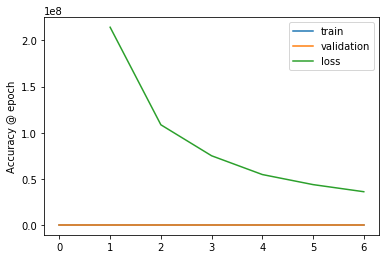

In [20]:
lr = 3e-4
epochs = 777
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr = lr)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr = lr)
from chamfer_distance_loss import MyNumberLoss, MyChamferDistance
loss = MyNumberLoss()

loss_history, train_history, val_history = train_model(
    encoder = rnn_encoder, 
    decoder = rnn_decoder, 
    train_loader = train_loader,
    val_loader = val_loader,
    loss = loss,
    decoder_opt = decoder_optimizer,
    encoder_opt = encoder_optimizer,
    epochs = epochs)

plot_history(loss_history, train_history, val_history)

In [22]:
from train import calculate_accuracy
i = 0
for (x, y) in iter(val_loader):
    outs, learned = rnn_encoder(x)
    decoded = rnn_decoder(outs, learned)
    
    yyy = []
    for yy in y:
        yyy.append(yy.shape[0])
    ppp = []
    for dd in decoded:
        ppp.append(dd.shape[0])
    
    print('yyy', yyy)
    print('prd', ppp)
    
    lv = loss(decoded, y)
    print ('loss', lv)

    acc = calculate_accuracy(decoded, y)
    print('acc', acc)

    i += 1
    print(i, '------------------------------')

yyy [100, 0]
prd [3618, 716]
loss tensor(6444490., grad_fn=<MseLossBackward>)
acc [0, 0]
1 ------------------------------
yyy [0, 0]
prd [901, 444]
loss tensor(504468.5000, grad_fn=<MseLossBackward>)
acc [0, 0]
2 ------------------------------
yyy [3]
prd [1194]
loss tensor(1418481., grad_fn=<MseLossBackward>)
acc [0]
3 ------------------------------


In [13]:
ii = pd.DataFrame(x[0].cpu().detach().numpy())
print(ii.head())
yy = pd.DataFrame(y[0].cpu().detach().numpy())
print(len(yy))
print(yy.head())
pp = pd.DataFrame(prediction[0].cpu().detach().numpy())
print(len(pp))
print(pp.head())

             0            1    2            3            4    5    6    7    8
0 -555457.0625 -1106056.625  0.0 -555457.0625 -1074272.375  0.0  0.0  0.0  0.0
1 -554857.0625 -1100368.125  0.0 -554857.0625 -1075168.125  0.0  0.0  0.0  0.0
2 -556057.0625 -1099168.125  0.0 -556057.0625 -1098593.125  0.0  0.0  0.0  0.0
3 -556057.0625 -1098443.125  0.0 -556057.0625 -1094368.125  0.0  0.0  0.0  0.0
4 -556057.0625 -1093168.125  0.0 -556057.0625 -1088368.125  0.0  0.0  0.0  0.0
259
             0            1    2            3            4    5
0 -617057.0625 -1075768.125  0.0 -617057.0625 -1081768.125  0.0
1 -617057.0625 -1087768.125  0.0 -617057.0625 -1093768.125  0.0
2 -617057.0625 -1093768.125  0.0 -617057.0625 -1099768.125  0.0
3 -619477.9375 -1075768.125  0.0 -622214.6250 -1099768.125  0.0
4 -616457.0625 -1100368.125  0.0 -610457.0625 -1100368.125  0.0
4334
          0    1         2    3    4         5
0 -0.997142 -1.0 -0.999987  1.0 -1.0  0.029111
1 -0.999512 -1.0 -0.999969  1.0 -1.0  0

In [14]:
from train import calculate_accuracy
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

test_accuracies = []
for (x,y) in test_loader:
    with torch.no_grad():
        out, hidden = rnn_encoder(x)
        prediction = rnn_decoder(out, hidden)
        accuracy = calculate_accuracy(prediction, y)
        test_accuracies.append(accuracy)
        
mean_test_accuracy = np.mean(test_accuracies)
print('Accuracy on testing: {0:2.3f}'.format(mean_test_accuracy))

TypeError: unsupported operand type(s) for /: 'list' and 'int'